In [1]:
import pandas     as pd
import tensorflow as tf
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from typing import Any, Tuple
from copy import deepcopy

2024-03-07 22:17:13.818880: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-07 22:17:13.850970: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 22:17:13.851004: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 22:17:13.852061: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-07 22:17:13.857860: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-07 22:17:13.858312: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
TESTING_WINDOW_SIZES = ['10min']
DATA_FOLDER          = './datasets/ambient_measurements/2022'
DATA_FILENAMES       = ['hum.csv', 'temp.csv']
VARIABLE_NAMES       = ['hum_level', 'temp_level']
PREFER_MAE_OVER_MSE  = False

SPLIT_DATE           = '2022-05-29 00:00:00'
INTERPOLATION_METHOD = 'linear'
INTERPOLATION_ORDER  = 3
RESAMPLE_FREQ        = '5min'

#MODEL PARAMETERS
PATIENCE             = 10
EPOCHS               = 100
WINDOW_SIZE          = 50 #keep in mind that each data point is 5 minutes apart
BATCH_SIZE           = 32 
TIMESTEPS_AHEAD      = 36 #keep in mind that each data point is 5 minutes apart
SHUFFLE_BUFFER_SIZE  = 1000

In [3]:
data = pd.read_csv(f"{DATA_FOLDER}/{DATA_FILENAMES[0]}", index_col=0, parse_dates=True)
data.head()

,hum_level
time,
2022-05-09 21:22:18,50.23
2022-05-09 21:24:48,50.30
2022-05-09 21:27:18,50.33
2022-05-09 21:32:18,50.37
2022-05-09 21:37:18,50.41


# Resample and Interpolate 

This is done to make the model more resilient to periods of time where there is no data. This is done by resampling the data to a fixed frequency and then interpolating the missing values.

In [4]:
data = data.interpolate(method=INTERPOLATION_METHOD, order=INTERPOLATION_ORDER).\
            resample(RESAMPLE_FREQ).mean().interpolate(method=INTERPOLATION_METHOD, order=INTERPOLATION_ORDER)

## Enriching the data

In [5]:
avg = data.rolling(window='30min', min_periods=1).mean().fillna(0)
std = data.rolling(window='30min', min_periods=1).std().bfill()

data['avg'] = avg
data['std'] = std
data.head()

,hum_level,avg,std
time,,,
2022-05-09 21:20:00,50.265,50.265000,0.045962
2022-05-09 21:25:00,50.330,50.297500,0.045962
2022-05-09 21:30:00,50.370,50.321667,0.052994
2022-05-09 21:35:00,50.410,50.343750,0.061830
2022-05-09 21:40:00,50.460,50.367000,0.074632


# Splitting the data

In [6]:
# Split the data into training and testing sets
train = deepcopy(data[:SPLIT_DATE])
test = deepcopy(data[SPLIT_DATE:])

# Plot the data
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train[VARIABLE_NAMES[0]], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=test.index, y=test[VARIABLE_NAMES[0]], mode='lines', name='Test'))
fig.update_layout(title='Humidity', xaxis_title='Time', yaxis_title='Humidity')
fig.update_layout(autosize=False, width=1500, height=500,)
fig.show()

# Prepare the data for training and testing

After the data has been resampled, interpolated, it is split into training and testing data. The training data is used to train the model and the testing data is used to evaluate the model.

In [7]:
def windowed_dataset(data: pd.DataFrame,
                     window_size: int,
                     batch_size: int,
                     shuffle_buffer: int,
                     timesteps_ahead: int = 12, 
                     shuffle: bool = True) -> tf.data.Dataset:

    """
    Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int)       - the number of time steps to average
      batch_size (int)        - the batch size
      timestep_ahead (int)    - the number of time steps to predict
      shuffle_buffer(int)     - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # extract the measurement value, the mean, and the standard deviation into an array like 
    # [ [measurement, mean, std], [measurement, mean, std], ...]
    series = np.array(data[VARIABLE_NAMES[0]])
    avg = np.array(data['avg'])
    std = np.array(data['std'])
    series = np.array([series, avg, std]).T


    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + timesteps_ahead, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + timesteps_ahead))

    # Create tuples with features and labels (labels are the last timesteps_ahead values of the window)
    # they don't use the avg and std values
    dataset = dataset.map(lambda window: (window[:-timesteps_ahead], window[-timesteps_ahead:, 0]))

    # Shuffle the windows
    if shuffle:
        dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [8]:
train_dataset = windowed_dataset(train, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE, TIMESTEPS_AHEAD)
test_dataset = windowed_dataset(test, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE, TIMESTEPS_AHEAD, shuffle=False)

2024-03-07 22:17:15.376056: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-07 22:17:15.376610: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
# Print properties of a single batch
for windows in train_dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 50, 3)
shape of second element: (32, 36)


# Build the baseline model

In [10]:
model_baseline = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[WINDOW_SIZE, 3]),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(TIMESTEPS_AHEAD),
])

model_baseline.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150)               0         
                                                                 
 dense (Dense)               (None, 10)                1510      
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 36)                396       
                                                                 
Total params: 2016 (7.88 KB)
Trainable params: 2016 (7.8

In [11]:
model_baseline.compile(loss      = tf.losses.MeanSquaredError(),
                       optimizer = "adam",
                       metrics   = ["mae", "mse"])

#patience callback of 5 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, mode='min')

# Train the model and save the history
history = model_baseline.fit(train_dataset,
                             epochs=EPOCHS,
                             validation_data=test_dataset,
                             callbacks=[early_stopping])

Epoch 1/100
170/170 [==============================] - 1s 4ms/step - loss: 1954.2094 - mae: 41.5122 - mse: 1954.2094 - val_loss: 851.9615 - val_mae: 24.7997 - val_mse: 851.9615
Epoch 2/100
170/170 [==============================] - 1s 4ms/step - loss: 776.4610 - mae: 21.4778 - mse: 776.4610 - val_loss: 210.0558 - val_mae: 14.1051 - val_mse: 210.0558
Epoch 3/100
170/170 [==============================] - 1s 5ms/step - loss: 623.9646 - mae: 18.2451 - mse: 623.9646 - val_loss: 195.7732 - val_mae: 13.8345 - val_mse: 195.7732
Epoch 4/100
170/170 [==============================] - 1s 4ms/step - loss: 591.8668 - mae: 17.9414 - mse: 591.8668 - val_loss: 164.7140 - val_mae: 12.6822 - val_mse: 164.7140
Epoch 5/100
170/170 [==============================] - 1s 4ms/step - loss: 588.0865 - mae: 18.1339 - mse: 588.0865 - val_loss: 160.5096 - val_mae: 12.5228 - val_mse: 160.5096
Epoch 6/100
170/170 [==============================] - 1s 4ms/step - loss: 584.2048 - mae: 18.1655 - mse: 584.2048 - val_lo

In [12]:
# Plot the loss and the MAE
fig = go.Figure()
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['loss'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['val_loss'], mode='lines', name='Test'))
fig.update_layout(title='Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()

In [13]:
baseline_eval = model_baseline.evaluate(test_dataset)

129/129 [==============================] - 0s 2ms/step - loss: 124.1214 - mae: 10.9972 - mse: 124.1214


In [14]:
def plot_random_predictions(model_baseline: Any,
                            test_dataset: Any,
                            N: int = 12,
                            COLS: int = 4) -> None:
    """
    Plots N random predictions from the model_baseline compared to expected values from the test_dataset.
    
    Parameters:
    - model_baseline: The model used for making predictions. It must have a .predict() method.
    - test_dataset: The dataset to test the model on, expected to yield tuples of (features, labels).
    - N: The number of random predictions to plot. Default is 12.
    - COLS: The number of columns in the subplot grid. Default is 4.
    
    Returns:
    None. Displays a matplotlib figure with the plots.
    """
    # Make predictions on the test dataset
    baseline_preds = model_baseline.predict(test_dataset)
    
    # Concatenate all expected labels from the test dataset
    inputs = np.concatenate([x for x, y in test_dataset], axis=0)
    inputs = inputs[:, :, 0]
    expected = np.concatenate([y for x, y in test_dataset], axis=0)
    
    print(f'Inputs shape: {inputs.shape}')
    print(f'Expected shape: {expected.shape}')
    
    # Randomly select N predictions for plotting
    samples = np.random.randint(0, len(baseline_preds), N)
    
    # Create subplots
    _, subplots = plt.subplots(N//COLS, COLS, figsize=(15, 10))
    subplots = subplots.ravel()
    
    # Plot each selected sample's expected vs. predicted values
    for i, sample in enumerate(samples):
        
        # concatenate the inputs and expected values, but plot the 
        # inputs in a different color than the expected values
        joint = np.concatenate([inputs[sample], expected[sample]])  
        xrange = range(len(joint))
        subplots[i].plot(xrange, joint, label='Expected', color='blue')
        subplots[i].plot(xrange, [None]*len(inputs[sample]) + list(baseline_preds[sample]), label='Predicted', color='red')
        subplots[i].legend()
        subplots[i].set_title(f'Prediction {sample}')
        
    plt.tight_layout()
    plt.show()


129/129 [==============================] - 0s 2ms/step
Inputs shape: (4120, 50)
Expected shape: (4120, 36)


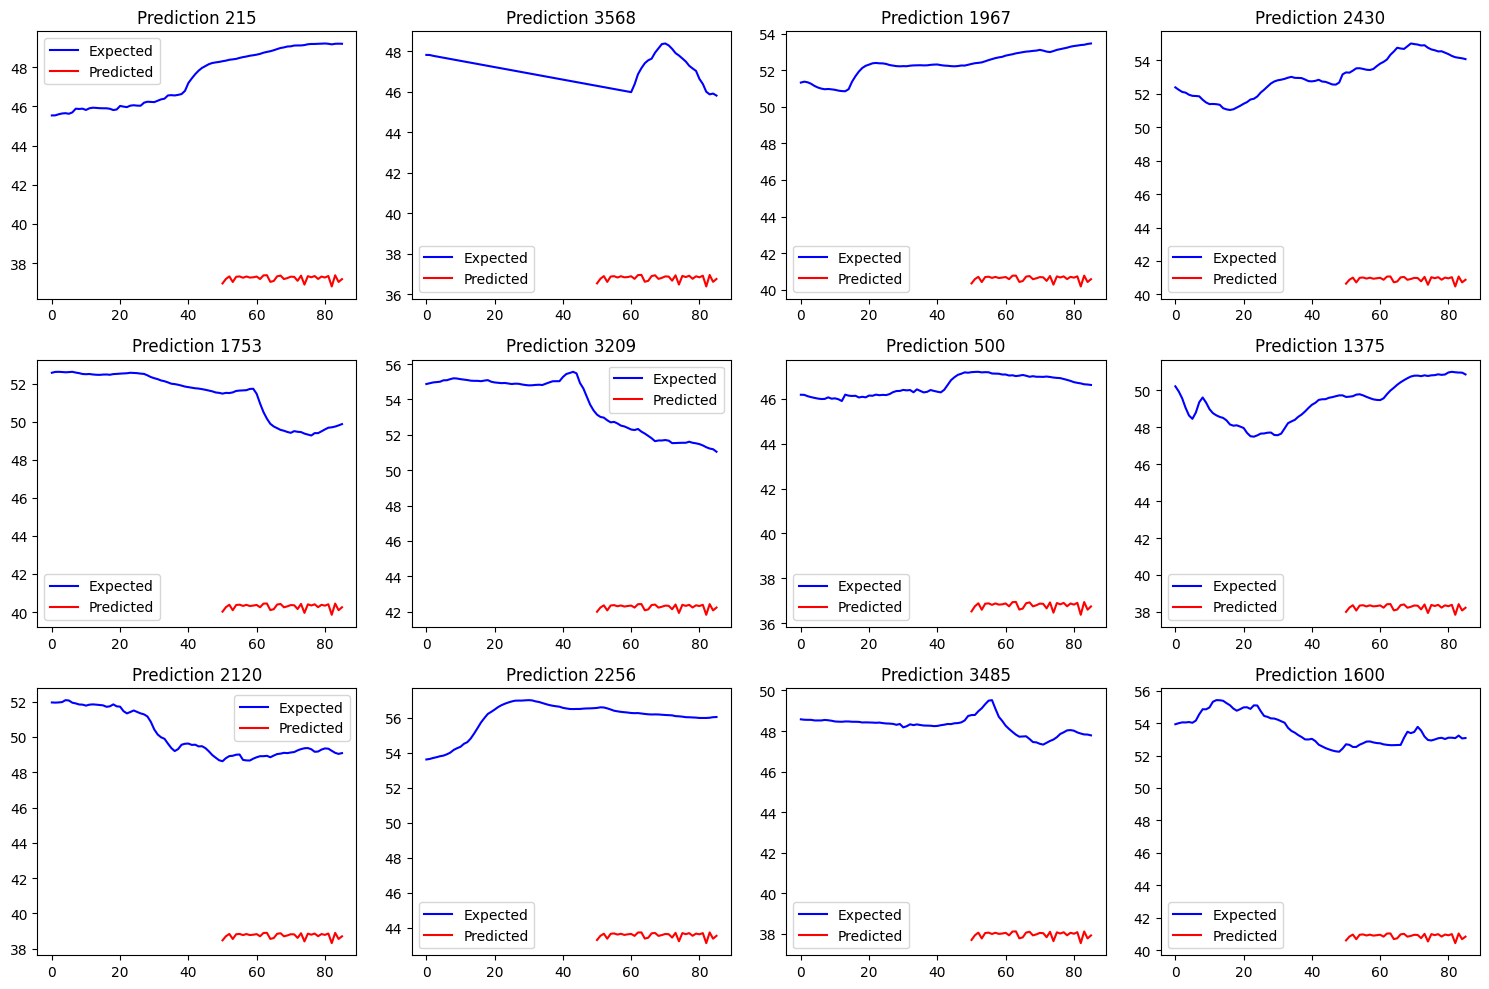

In [15]:
plot_random_predictions(model_baseline, test_dataset, N=12, COLS=4)

# Now that we have some benchmark, lets build the model


In [16]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[WINDOW_SIZE, 3]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
    tf.keras.layers.Conv1D(filters=3, kernel_size=3, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.Conv1D(filters=3, kernel_size=3, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.Conv1D(filters=3, kernel_size=3, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(TIMESTEPS_AHEAD),
    tf.keras.layers.Lambda(lambda x: x * 100)
])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150)               0         
                                                                 
 lambda (Lambda)             (None, 150, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 150, 3)            12        
                                                                 
 conv1d_1 (Conv1D)           (None, 150, 3)            30        
                                                                 
 conv1d_2 (Conv1D)           (None, 150, 3)            30        
                                                                 
 flatten_2 (Flatten)         (None, 450)               0         
                                                                 
 dropout_2 (Dropout)         (None, 450)              

In [17]:
model1.compile(loss = tf.losses.MeanSquaredError(),
               optimizer = "adam",
               metrics   = ["mae", "mse"])

#patience callback of 5 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, mode='min')

# Train the model and save the history
history = model1.fit(train_dataset,
                     epochs=EPOCHS,
                     validation_data=test_dataset,
                     callbacks=[early_stopping])

# Plot the loss and the MAE
fig = go.Figure()
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['loss'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['val_loss'], mode='lines', name='Test'))
fig.update_layout(title='Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()

Epoch 1/100
170/170 [==============================] - 2s 5ms/step - loss: 77899.8516 - mae: 97.6807 - mse: 77899.8516 - val_loss: 2190.5000 - val_mae: 46.6224 - val_mse: 2190.5000
Epoch 2/100
170/170 [==============================] - 1s 4ms/step - loss: 1738.9697 - mae: 41.1727 - mse: 1738.9697 - val_loss: 1721.4260 - val_mae: 41.1591 - val_mse: 1721.4260
Epoch 3/100
170/170 [==============================] - 1s 5ms/step - loss: 1299.8630 - mae: 35.3397 - mse: 1299.8630 - val_loss: 1286.4578 - val_mae: 35.2585 - val_mse: 1286.4578
Epoch 4/100
170/170 [==============================] - 1s 5ms/step - loss: 937.4119 - mae: 29.4925 - mse: 937.4119 - val_loss: 930.7153 - val_mae: 29.5369 - val_mse: 930.7153
Epoch 5/100
170/170 [==============================] - 1s 5ms/step - loss: 651.1102 - mae: 23.9766 - mse: 651.1102 - val_loss: 659.2163 - val_mae: 24.3234 - val_mse: 659.2163
Epoch 6/100
170/170 [==============================] - 1s 5ms/step - loss: 448.8298 - mae: 19.0922 - mse: 448.8

129/129 [==============================] - 0s 2ms/step
Inputs shape: (4120, 50)
Expected shape: (4120, 36)


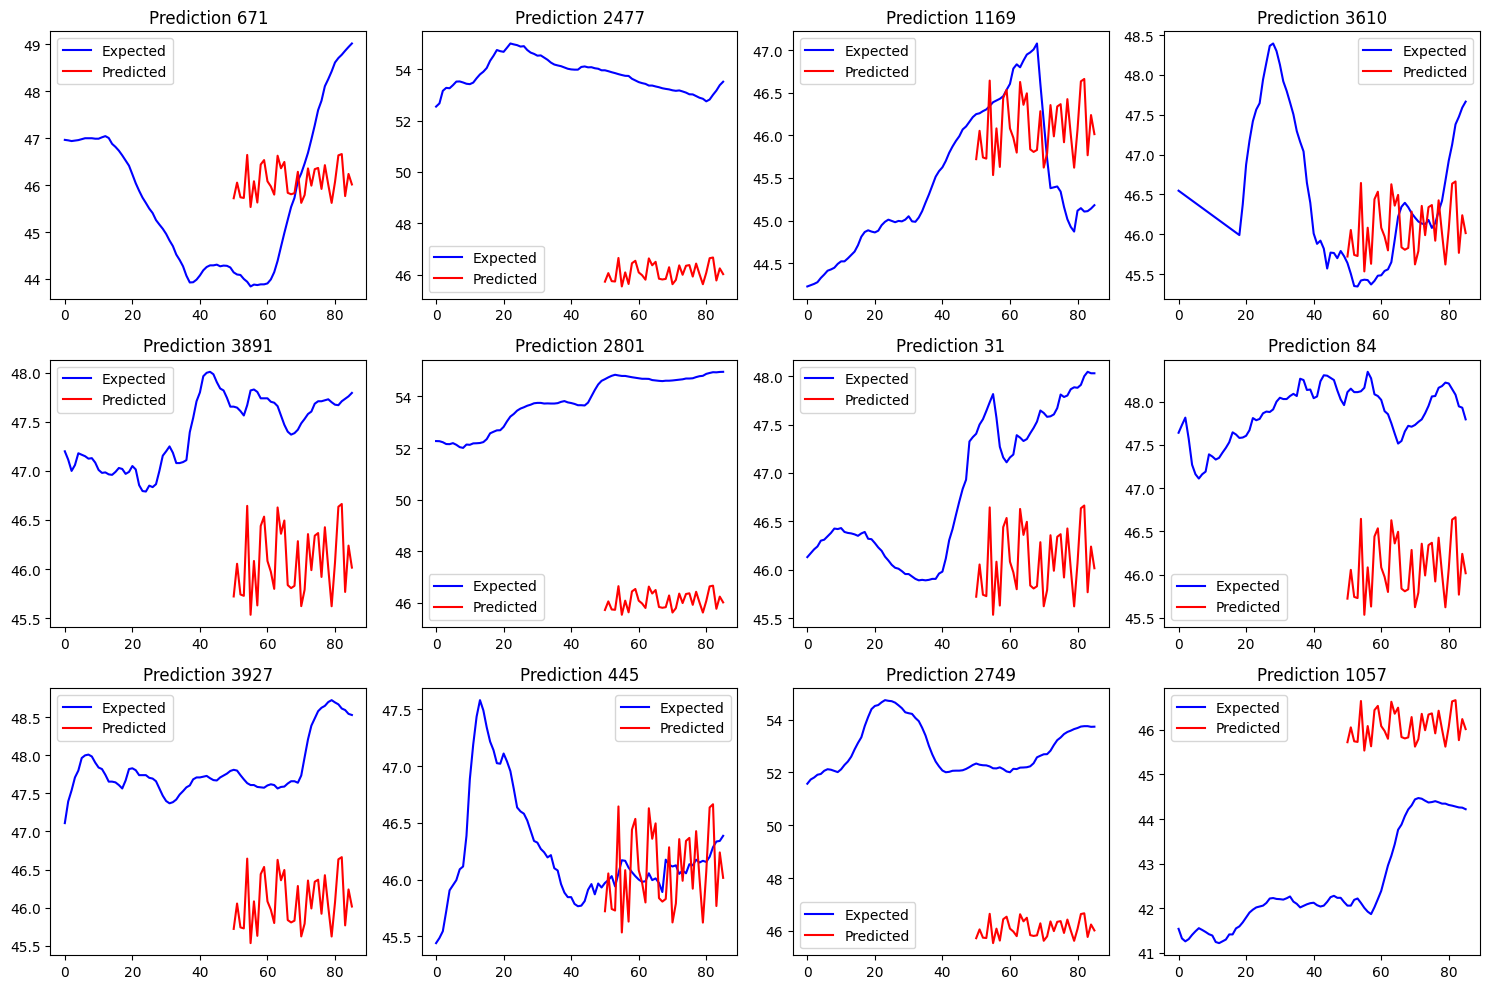

In [18]:
model1_eval = model1.evaluate(test_dataset)
plot_random_predictions(model1, test_dataset, N=12, COLS=4)

In [19]:
print(f"Baseline model: {baseline_eval}")
print(f"Model 1: {model1_eval}")

Baseline model: [124.1213607788086, 10.997246742248535, 124.1213607788086]
Model 1: [27.638093948364258, 4.457184791564941, 27.638093948364258]


# Create a more complex model

In [37]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[WINDOW_SIZE, 3]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),

    tf.keras.layers.Conv1D(filters=6, kernel_size=6, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=2),

    tf.keras.layers.Conv1D(filters=6, kernel_size=6, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=2),

    tf.keras.layers.GRU(30, return_sequences=True),
    tf.keras.layers.GRU(30, return_sequences=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(TIMESTEPS_AHEAD),
    tf.keras.layers.Lambda(lambda x: x * 100)
])
model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_13 (Flatten)        (None, 150)               0         
                                                                 
 lambda_12 (Lambda)          (None, 150, 1)            0         
                                                                 
 conv1d_14 (Conv1D)          (None, 150, 6)            42        
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 75, 6)             0         
 ng1D)                                                           
                                                                 
 conv1d_15 (Conv1D)          (None, 75, 6)             222       
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 37, 6)             0         
 ng1D)                                                

In [38]:
model2.compile(loss = tf.losses.MeanSquaredError(),
               optimizer = "adam",
               metrics   = ["mae", "mse"])

#patience callback of 5 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, mode='min')

# Train the model and save the history
history = model2.fit(train_dataset,
                     epochs=EPOCHS,
                     validation_data=test_dataset,
                     callbacks=[early_stopping])

# Plot the loss and the MAE
fig = go.Figure()
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['loss'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['val_loss'], mode='lines', name='Test'))
fig.update_layout(title='Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()

Epoch 1/100
170/170 [==============================] - 5s 16ms/step - loss: 154.3754 - mae: 4.6317 - mse: 154.3754 - val_loss: 6.7720 - val_mae: 2.0528 - val_mse: 6.7720
Epoch 2/100
170/170 [==============================] - 2s 12ms/step - loss: 6.2899 - mae: 1.9654 - mse: 6.2899 - val_loss: 9.8270 - val_mae: 2.5559 - val_mse: 9.8270
Epoch 3/100
170/170 [==============================] - 2s 11ms/step - loss: 5.8757 - mae: 1.8944 - mse: 5.8757 - val_loss: 9.1975 - val_mae: 2.4540 - val_mse: 9.1975
Epoch 4/100
170/170 [==============================] - 2s 12ms/step - loss: 5.6324 - mae: 1.8570 - mse: 5.6324 - val_loss: 7.7360 - val_mae: 2.2035 - val_mse: 7.7360
Epoch 5/100
170/170 [==============================] - 2s 12ms/step - loss: 6.0523 - mae: 1.9312 - mse: 6.0523 - val_loss: 8.1593 - val_mae: 2.2750 - val_mse: 8.1593
Epoch 6/100
170/170 [==============================] - 2s 11ms/step - loss: 5.5874 - mae: 1.8593 - mse: 5.5874 - val_loss: 5.8078 - val_mae: 1.9007 - val_mse: 5.8078


      1/Unknown - 0s 21ms/step - loss: 4.0008 - mae: 1.7328 - mse: 4.0008

129/129 [==============================] - 1s 3ms/step
Inputs shape: (4120, 50)
Expected shape: (4120, 36)


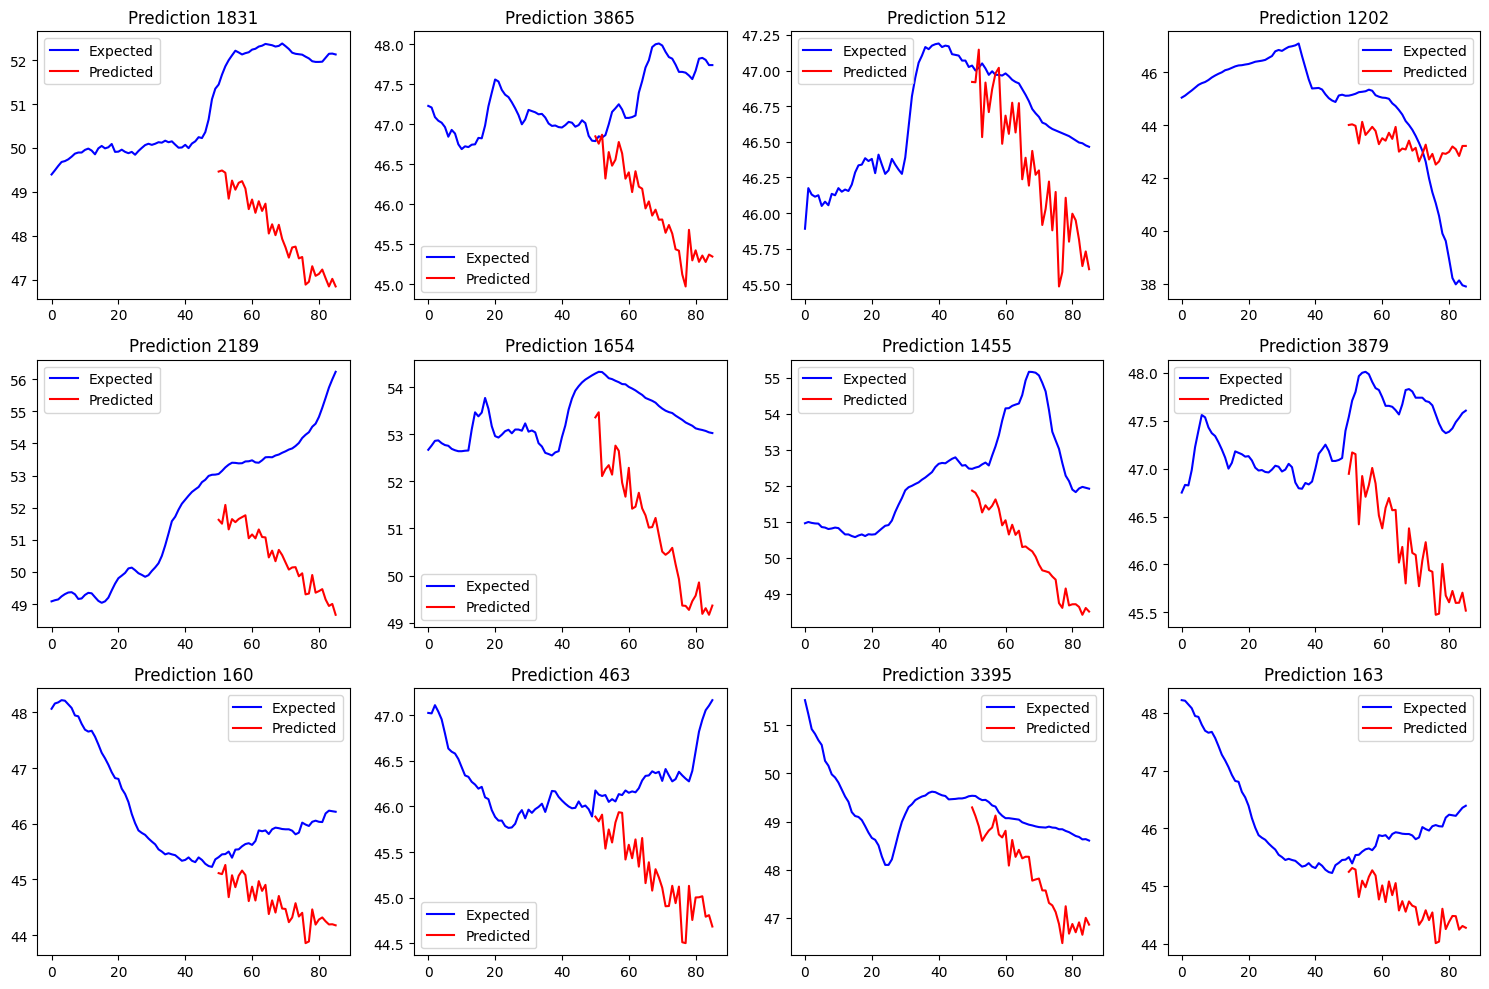

In [39]:
model2_eval = model2.evaluate(test_dataset)
plot_random_predictions(model2, test_dataset, N=12, COLS=4)

In [40]:
print(f"Baseline model: {baseline_eval}")
print(f"Model 1: {model1_eval}")
print(f"Model 2: {model2_eval}")

Baseline model: [124.1213607788086, 10.997246742248535, 124.1213607788086]
Model 1: [27.638093948364258, 4.457184791564941, 27.638093948364258]
Model 2: [8.345894813537598, 2.357120990753174, 8.345894813537598]


# More testing models

In [70]:
model3 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[WINDOW_SIZE, 3]),

    tf.keras.layers.Conv1D(filters=12, kernel_size=6, strides=3, padding="causal", activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=1),

    tf.keras.layers.GRU(30, return_sequences=True),
    tf.keras.layers.GRU(30, return_sequences=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(TIMESTEPS_AHEAD),
    tf.keras.layers.Lambda(lambda x: x * 100)
])
model3.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_34 (Conv1D)          (None, 17, 12)            228       
                                                                 
 max_pooling1d_31 (MaxPooli  (None, 16, 12)            0         
 ng1D)                                                           
                                                                 
 gru_34 (GRU)                (None, 16, 30)            3960      
                                                                 
 gru_35 (GRU)                (None, 16, 30)            5580      
                                                                 
 flatten_27 (Flatten)        (None, 480)               0         
                                                                 
 dense_22 (Dense)            (None, 36)                17316     
                                                     

In [71]:
model3.compile(loss = tf.losses.MeanSquaredError(),
               optimizer = "adam",
               metrics   = ["mae", "mse"])

#patience callback of 5 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, mode='min')

# Train the model and save the history
history = model3.fit(train_dataset,
                     epochs=EPOCHS,
                     validation_data=test_dataset,
                     callbacks=[early_stopping])

# Plot the loss and the MAE
fig = go.Figure()
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['loss'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['val_loss'], mode='lines', name='Test'))
fig.update_layout(title='Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()

Epoch 1/100
170/170 [==============================] - 4s 11ms/step - loss: 88.3495 - mae: 4.1639 - mse: 88.3495 - val_loss: 19.3191 - val_mae: 3.6453 - val_mse: 19.3191
Epoch 2/100
170/170 [==============================] - 2s 9ms/step - loss: 6.5075 - mae: 1.9888 - mse: 6.5075 - val_loss: 8.2787 - val_mae: 2.2789 - val_mse: 8.2787
Epoch 3/100
170/170 [==============================] - 2s 9ms/step - loss: 5.5128 - mae: 1.8280 - mse: 5.5128 - val_loss: 9.9725 - val_mae: 2.5762 - val_mse: 9.9725
Epoch 4/100
170/170 [==============================] - 2s 9ms/step - loss: 5.5367 - mae: 1.8374 - mse: 5.5367 - val_loss: 18.5469 - val_mae: 3.7454 - val_mse: 18.5469
Epoch 5/100
170/170 [==============================] - 2s 9ms/step - loss: 5.8545 - mae: 1.8872 - mse: 5.8545 - val_loss: 10.2568 - val_mae: 2.6038 - val_mse: 10.2568
Epoch 6/100
170/170 [==============================] - 1s 8ms/step - loss: 4.7834 - mae: 1.7006 - mse: 4.7834 - val_loss: 10.4821 - val_mae: 2.6817 - val_mse: 10.4821

129/129 [==============================] - 1s 3ms/step
Inputs shape: (4120, 50)
Expected shape: (4120, 36)


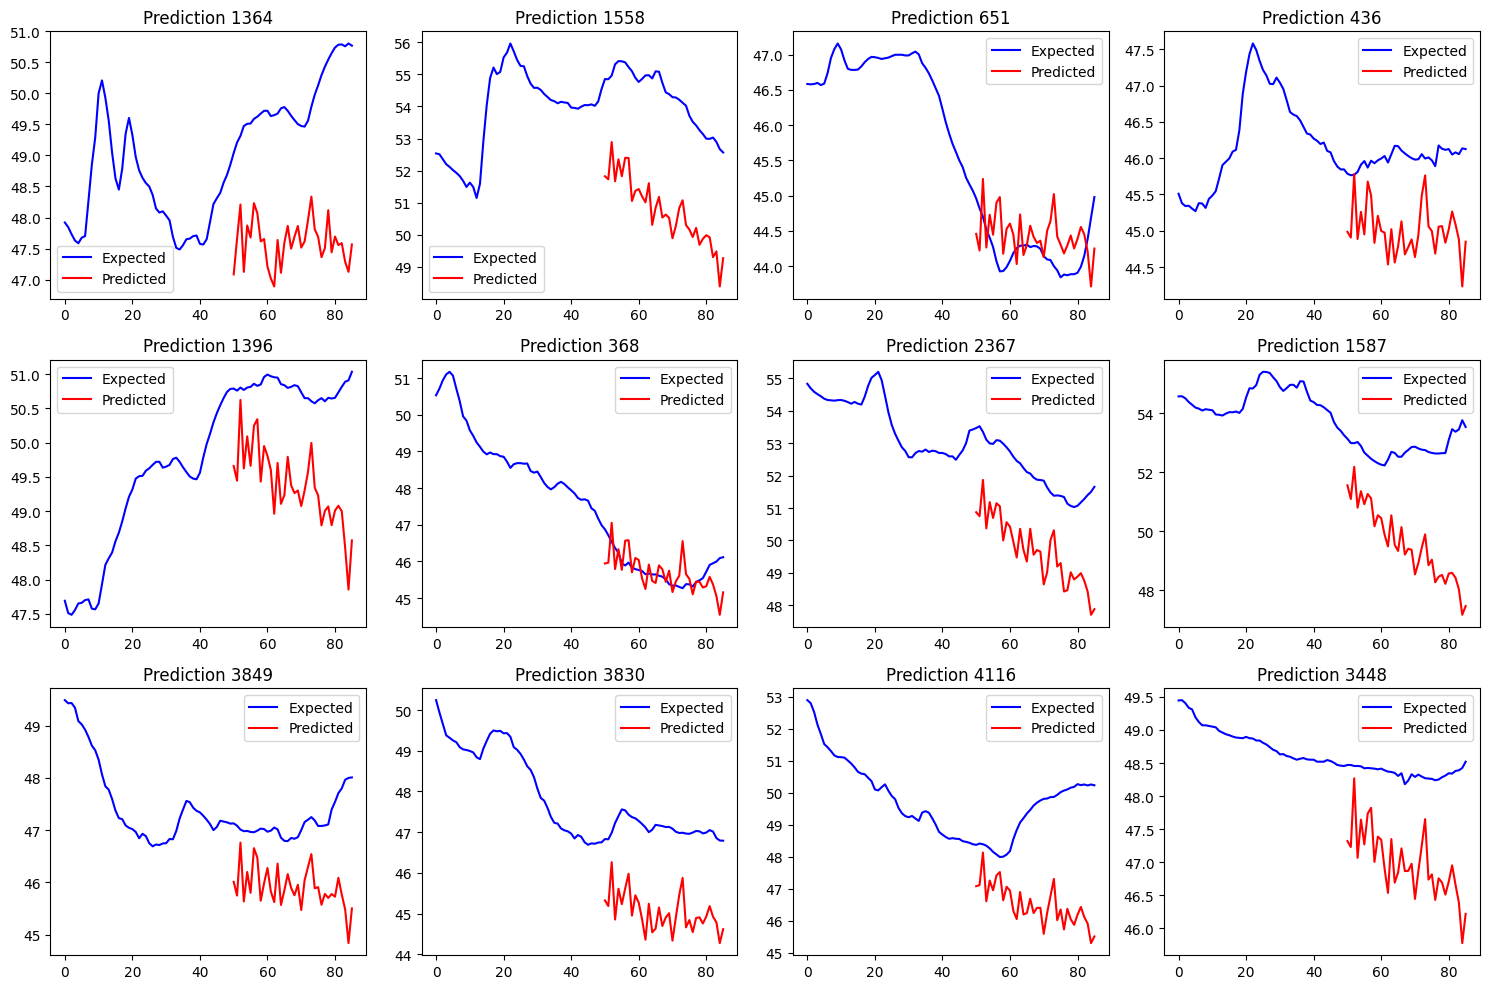

In [72]:
model3_eval = model3.evaluate(test_dataset)
plot_random_predictions(model3, test_dataset, N=12, COLS=4)

In [73]:
print(f"Baseline model: {baseline_eval}")
print(f"Model 1: {model1_eval}")
print(f"Model 2: {model2_eval}")
print(f"Model 3: {model3_eval}")

Baseline model: [124.1213607788086, 10.997246742248535, 124.1213607788086]
Model 1: [27.638093948364258, 4.457184791564941, 27.638093948364258]
Model 2: [8.345894813537598, 2.357120990753174, 8.345894813537598]
Model 3: [6.5360493659973145, 2.1132638454437256, 6.5360493659973145]


# last model 

In [84]:
model4 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[WINDOW_SIZE, 3]),

    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(30, return_sequences=True, activation="relu")),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(30, return_sequences=True, activation="relu")),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(TIMESTEPS_AHEAD),
])
model4.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 50, 60)            6300      
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 50, 60)            16560     
 onal)                                                           
                                                                 
 flatten_31 (Flatten)        (None, 3000)              0         
                                                                 
 dense_26 (Dense)            (None, 36)                108036    
                                                                 
Total params: 130896 (511.31 KB)
Trainable params: 130896 (511.31 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [85]:
model4.compile(loss = tf.losses.MeanSquaredError(),
               optimizer = "adam",
               metrics   = ["mae", "mse"])

#patience callback of 5 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, mode='min')

# Train the model and save the history
history = model4.fit(train_dataset,
                     epochs=EPOCHS,
                     validation_data=test_dataset,
                     callbacks=[early_stopping])

# Plot the loss and the MAE
fig = go.Figure()
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['loss'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['val_loss'], mode='lines', name='Test'))
fig.update_layout(title='Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()

Epoch 1/100
170/170 [==============================] - 7s 29ms/step - loss: 80.5450 - mae: 4.0846 - mse: 80.5450 - val_loss: 2.8187 - val_mae: 1.2446 - val_mse: 2.8187
Epoch 2/100
170/170 [==============================] - 5s 26ms/step - loss: 2.7417 - mae: 1.2304 - mse: 2.7417 - val_loss: 3.1587 - val_mae: 1.3243 - val_mse: 3.1587
Epoch 3/100
170/170 [==============================] - 5s 27ms/step - loss: 2.2576 - mae: 1.0821 - mse: 2.2576 - val_loss: 5.9696 - val_mae: 2.0178 - val_mse: 5.9696
Epoch 4/100
170/170 [==============================] - 5s 26ms/step - loss: 2.2534 - mae: 1.0704 - mse: 2.2534 - val_loss: 4.7477 - val_mae: 1.7621 - val_mse: 4.7477
Epoch 5/100
170/170 [==============================] - 5s 26ms/step - loss: 2.1859 - mae: 1.0505 - mse: 2.1859 - val_loss: 4.9491 - val_mae: 1.8458 - val_mse: 4.9491
Epoch 6/100
170/170 [==============================] - 5s 27ms/step - loss: 2.1864 - mae: 1.0594 - mse: 2.1864 - val_loss: 4.3464 - val_mae: 1.6657 - val_mse: 4.3464
Ep

      9/Unknown - 0s 7ms/step - loss: 0.6544 - mae: 0.6291 - mse: 0.6544 

129/129 [==============================] - 1s 6ms/step
Inputs shape: (4120, 50)
Expected shape: (4120, 36)


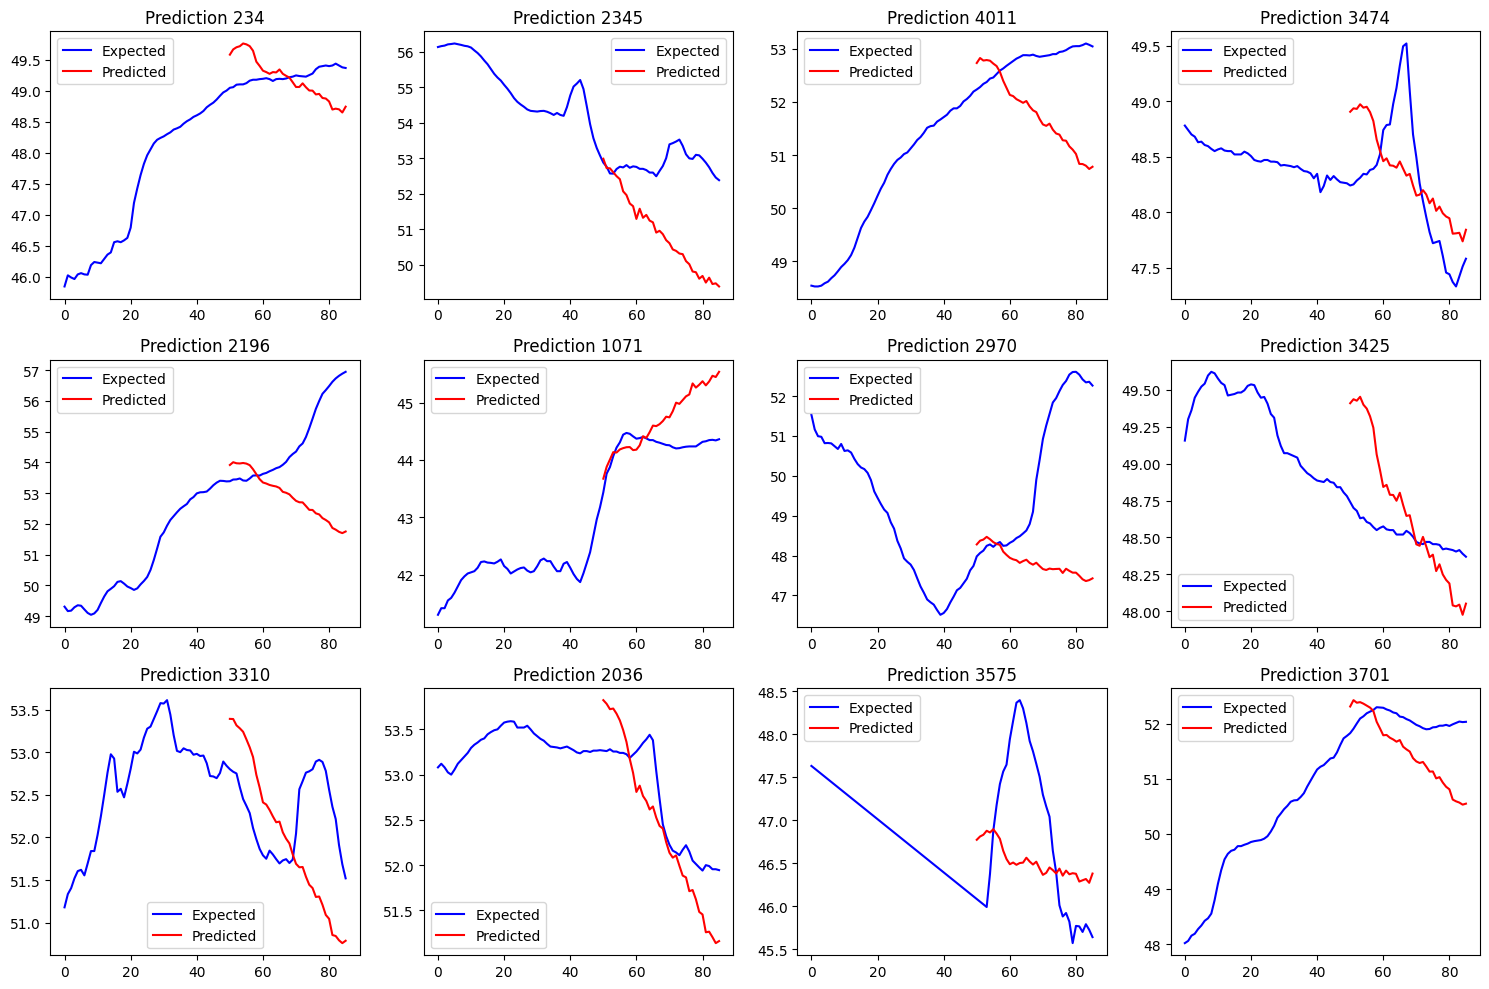

In [86]:
model4_eval = model4.evaluate(test_dataset)
plot_random_predictions(model4, test_dataset, N=12, COLS=4)

In [87]:
print(f"Baseline model: {baseline_eval}")
print(f"Model 1: {model1_eval}")
print(f"Model 2: {model2_eval}")
print(f"Model 3: {model3_eval}")
print(f"Model 4: {model4_eval}")

Baseline model: [124.1213607788086, 10.997246742248535, 124.1213607788086]
Model 1: [27.638093948364258, 4.457184791564941, 27.638093948364258]
Model 2: [8.345894813537598, 2.357120990753174, 8.345894813537598]
Model 3: [6.5360493659973145, 2.1132638454437256, 6.5360493659973145]
Model 4: [2.1206841468811035, 1.0562788248062134, 2.1206841468811035]
